In [2]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
import warnings
import seaborn as sns
import datetime

sns.set_style('white')

In [3]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False 

# Parameter selection of gold forecast

In [4]:
df = pd.read_csv('C_DATA\GLD-USD.csv')

In [5]:
def is_week_lastday(x):
    # 假如今天是周日
    sunday = x.weekday()
    # 如果今天是周日，则返回True
    if sunday in [5,6]:
        return 0
    else:
        return 1
df['Date'] = pd.to_datetime(df['Date'])
df['DealDay'] = df['Date'].map(lambda x: is_week_lastday(x))

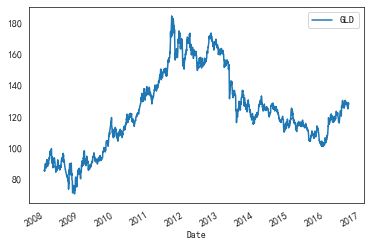

In [6]:
df.plot('Date','GLD')
plt.show()

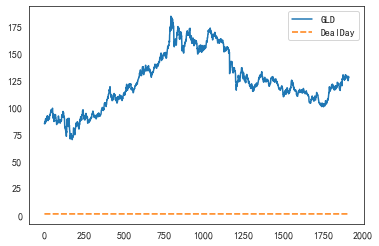

,Date,GLD,DealDay
0,2008-01-02,84.860001,1
1,2008-01-03,85.570000,1
2,2008-01-04,85.129997,1
3,2008-01-07,84.769997,1
4,2008-01-08,86.779999,1
...,...,...,...
1909,2016-08-31,124.779999,1
1910,2016-09-01,125.290001,1
1911,2016-09-06,128.710007,1
1912,2016-09-07,128.270004,1


In [7]:
sns.lineplot(data=df)
plt.show()
df

In [8]:
data = df['GLD'][df['DealDay']==1].copy()
# data = df['USD (PM)'][1:].copy()
data_diff=data
data_diff.index=df['Date'][df['DealDay']==1].copy()
# data_diff.index=df['Date'][1:].copy()
data_diff=data_diff.diff(1).dropna()
diff_df = pd.DataFrame()
diff_df['diff_1'] =  data_diff
diff_df['diff_2'] = data_diff.diff(1).dropna()
diff_df['diff_3'] = diff_df['diff_2'].diff(1).dropna()

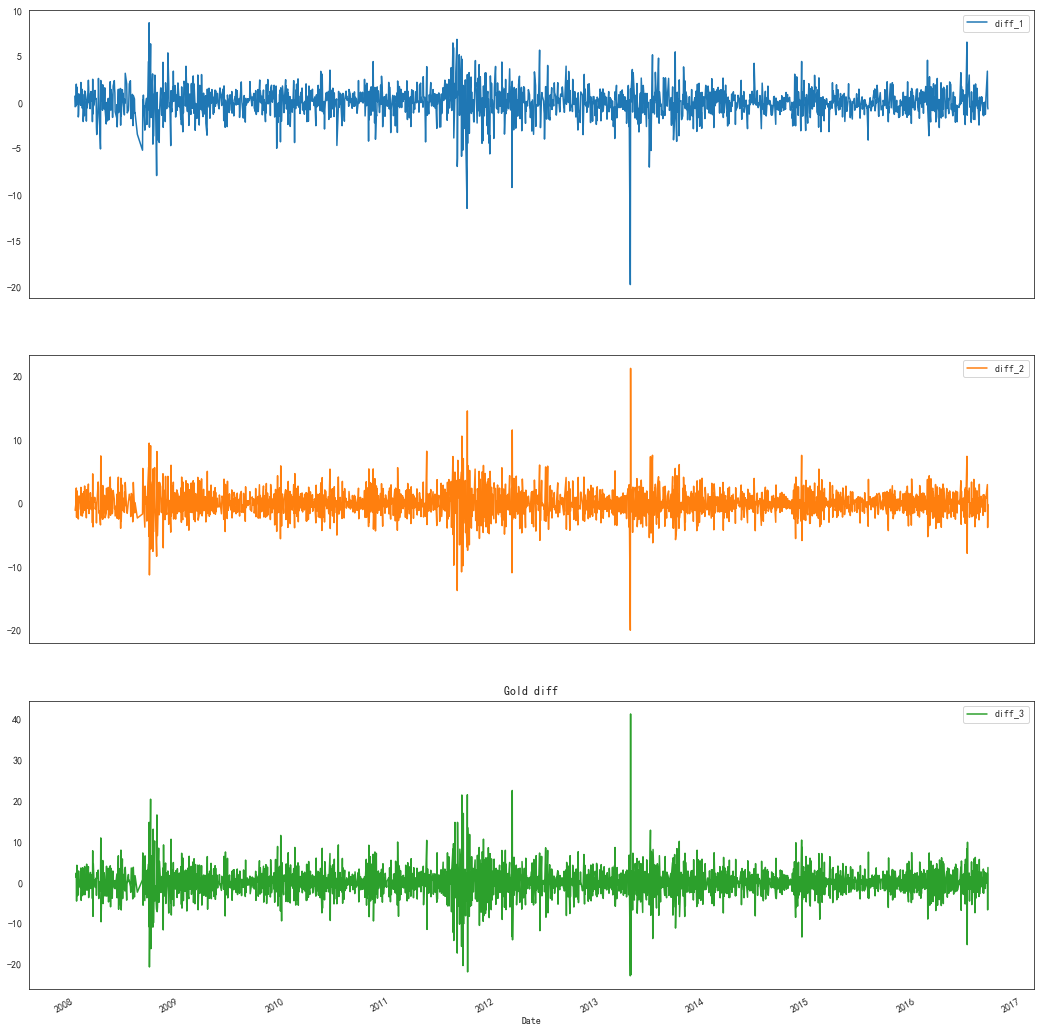

In [9]:
diff_df.plot(subplots=True,figsize=(18,20))
plt.title('Gold diff')
plt.show()
# 对比选择几阶差分,肉眼观察数据平稳性

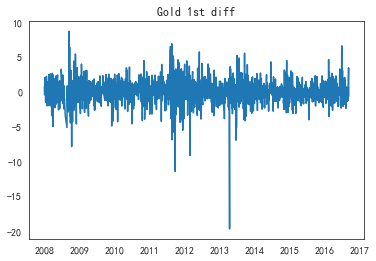

In [10]:
plt.plot(data_diff)
plt.title('Gold 1st diff')
plt.show()

adfuller单位根检验数据平稳性  
输出结果中：  
第一个是adt检验的结果，简称为T值，表示t统计量。  
第二个简称为p值，表示t统计量对应的概率值。  
第三个表示延迟。  
第四个表示测试的次数。  
第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。  

第一点，1%、5%、10%不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设。  
第二点，p值要求小于给定的显著水平，p值要小于0.05，等于0是最好的。
ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。  
（原假设为不是平稳时间序列)

In [11]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(data))  # 原始数据
print(adfuller(diff_df['diff_1'].dropna()))  # 一阶差分
print(adfuller(diff_df['diff_2'].dropna()))  # 二阶差分
print(adfuller(diff_df['diff_3'].dropna()))  # 三阶差分

(-1.7511519609138395, 0.4049686002668991, 3, 1910, {'1%': -3.4337783299766884, '5%': -2.863054412423824, '10%': -2.567576215016036}, 7233.4623806721775)
(-26.412415961844342, 0.0, 2, 1910, {'1%': -3.4337783299766884, '5%': -2.863054412423824, '10%': -2.567576215016036}, 7231.262133260176)
(-13.85732351703199, 6.829715746267368e-26, 26, 1885, {'1%': -3.4338238606869878, '5%': -2.863074513221476, '10%': -2.5675869178703854}, 7318.143763099497)
(-18.486657703056302, 2.1295875196473925e-30, 26, 1884, {'1%': -3.433825707083533, '5%': -2.8630753283581076, '10%': -2.567587351898432}, 7494.648873042439)


原始数据的P值>0.05所以不满足平稳性要求  
一阶差分的P值<0.05，且T值小于1%，5%，10%下的统计值，可以极显著的拒绝原假设，说明数据是平稳的。  
一阶差分数据已经平稳就无需继续做二阶差分了。  

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data_diff, lags = 20)

,lb_stat,lb_pvalue
1,3.544683,0.059737
2,4.522480,0.104221
3,9.024058,0.028973
4,9.024073,0.060501
5,10.569213,0.060623
6,10.755934,0.096219
7,11.213519,0.129573
8,11.316523,0.184401
9,15.539403,0.077146
10,19.373494,0.035767


acorr_ljungbox输出结果的第二项为基于卡方分布的p统计量，一阶差分的P值都很小，所以该数据拒绝原假设，即认为该数据不是纯随机数据  
不是纯随机数才可以做时间序列分析

# 观察法选择p,q
|模型|ACF|PACF|
|-|-|-|
|AR(p)|衰减趋于零(几何型或振荡型)|p阶后截尾|
|MA(q)|q阶后截尾|衰减趋于零(几何型或振荡型)|
|ARMA(p,q)|q阶后衰减趋于零(几何型或振荡型)|p阶后衰减趋于零(几何型或振荡型)|

截尾:落在置信区间内( 95%的点都符合该规则)

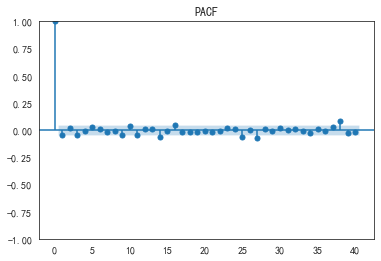

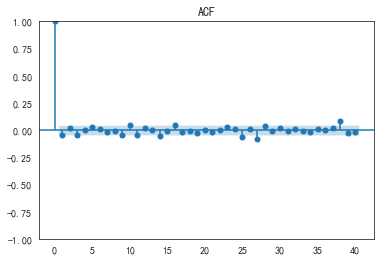

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(data_diff, lags=40)
plt.title('PACF')
plt.savefig('PACF图.png')
pacf.show()
acf = plot_acf(data_diff, lags=40)
plt.title('ACF')
plt.savefig('ACF图.png')
acf.show()

# 穷举法选择最好的p,q
max_ar和max_ma为最大可取参数，数值较大时运行结果较长。建议为5

In [14]:
# import statsmodels.tsa.stattools as st
# model = st.arma_order_select_ic(data_diff, max_ar=5, max_ma=5, ic=['aic', 'bic', 'hqic'])
# model.bic_min_order 
# 结果为(p,q)

训练ARIMA模型  
order参数里的三个值分别为（p,d阶差分,q）  
对于使用穷举法得出结果为0,0,且绘制出的图形效果较差时，可以根据肉眼观察图主动选择

In [31]:
train_df = pd.read_csv('C_DATA\Gold Price(1).csv')
train_df

,Unnamed: 0,Date,Price
0,0,0,1324.60
1,1,1,1323.65
2,2,2,1321.75
3,3,3,1310.80
4,4,4,1308.35
...,...,...,...
1260,1260,1820,1821.60
1261,1261,1821,1802.15
1262,1262,1822,1786.00
1263,1263,1823,1788.25


In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(train_df['Price'].values.reshape(-1, 1))
x

array([[-0.5774603 ],
       [-0.57947846],
       [-0.58351479],
       ...,
       [ 0.40272983],
       [ 0.40750969],
       [ 0.42099952]])

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
result_pred = []
for i in tqdm(range(6, len(train_df))):
    model = ARIMA(x[:i], order=(4,1,4))
    try:
        result = model.fit()
        result_pred.append(result.forecast(step=1)[0])
    except:
        result_pred.append(np.nan)
result_pred

100%|██████████| 1259/1259 [08:54<00:00,  2.35it/s]


[-0.5958479964741108,
 -0.6035978651409601,
 -0.5717936440437625,
 -0.5584302697855874,
 -0.5370565616007937,
 -0.5520317730201131,
 -0.6146584184443746,
 -0.5846150119256899,
 -0.6032226293366281,
 nan,
 nan,
 nan,
 -0.7127333705720907,
 -0.7246728085438978,
 -0.6934965850650403,
 -0.7270200074462616,
 -0.7398224943150357,
 -0.7200467509653025,
 -0.6956915705513518,
 -0.7492635376712505,
 -0.728059558423134,
 -0.7226765324295383,
 -0.6746871332458817,
 -0.7005574615001021,
 -0.7007604752871022,
 -0.7056217894601775,
 -0.6840548396692886,
 -0.6952616083358241,
 -0.703266369088656,
 -0.684171391664398,
 -0.6797990074978395,
 -0.6462663948284849,
 -0.6082977723230254,
 -0.625454069231305,
 -0.635311310970358,
 -0.6826042311420111,
 -0.6589656662823404,
 -0.6754401536350733,
 -0.7038412696990667,
 -0.8124379414084852,
 -0.8257646557023921,
 -0.7562004802264438,
 -0.7777072275807151,
 -0.7991652990975939,
 -0.836161955950479,
 -0.7859433158303435,
 -0.8127674273995805,
 -0.919743652594839,

In [34]:
len(x)

1265

In [35]:
len(result_pred)

1259

In [37]:
pred_price = np.array([np.nan] * 6 + result_pred)
is_nan = np.isnan(pred_price)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(scaler.inverse_transform(pred_price[~is_nan].reshape(-1, 1)), scaler.inverse_transform(x[~is_nan].reshape(-1, 1)), squared=True))

195.15271122506527


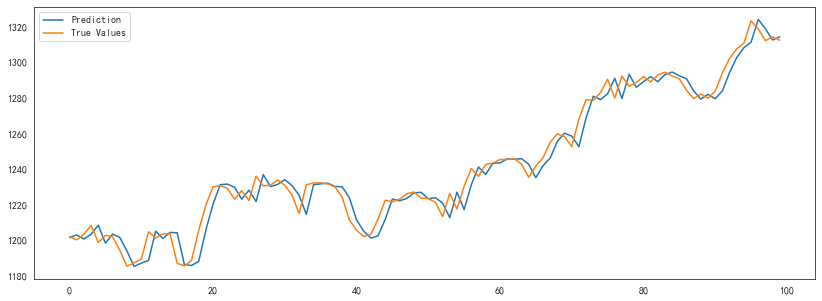

In [39]:
plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(pred_price[~is_nan].reshape(-1, 1)).flatten()[500:600], label = 'Prediction')
plt.plot(scaler.inverse_transform(x[~is_nan].reshape(-1, 1)).flatten()[500:600], label = 'True Values')
plt.legend()
plt.show()

In [23]:
np.isnan(np.array(result_pred)).sum()

3

残差检验  
如果残差是白噪声序列，说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的。  
qq图中：如果是正态分布则为一条直线，即红线。结果大致符合白噪声

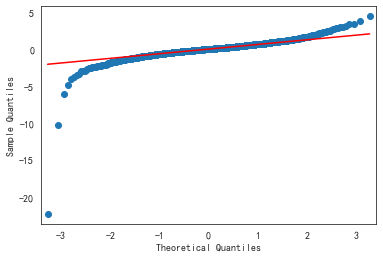

In [18]:
resid = result.resid
from statsmodels.graphics.api import qqplot
qqplot(resid, line='q', fit=True)
plt.savefig('黄金arima残差QQ图.png')
plt.show()

Durbin-Watson 检验，又称 DW 检验，是用来检验回归分析中残差的一阶自相关性的(尤其针对时间序列数据)。  
该统计量值越接近 2 越好，一般在 1~3 之间说明没问题，小于 1 这说明残差存在自相关性

In [19]:
import statsmodels.api as sm
print(sm.stats.durbin_watson(resid.values))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# result.summary()

预测  
predict(起始时间，终止时间)，预测出的结果也为一阶差分，即黄金的涨幅

In [ ]:
ts = pd.to_datetime(str(df['Date'].values[-1])).strftime("%Y-%m-%d")
ts

'2016-09-08'

In [ ]:
t1 = pd.to_datetime(str(df['Date'].values[-1])).strftime("%Y-%m-%d")
t0 = pd.to_datetime(str(df['Date'].values[0])).strftime("%Y-%m-%d")
train_size = int(len(data)*2/3)
t_m = pd.to_datetime(str(df['Date'].values[train_size])).strftime("%Y-%m-%d")

# pred = result.predict(t_m,t1)
pred = result.forecast(steps=2)
print(len(pred))
print(pred[-10:])

2
1914    127.480964
1915    127.486346
Name: predicted_mean, dtype: float64


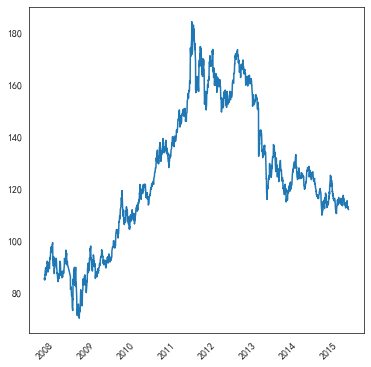

In [ ]:
plt.figure(figsize=(6, 6))
plt.xticks(rotation=45)
# plt.plot(data_diff)
plt.plot(pred)
plt.plot()
# plt.savefig('黄金预测涨幅.png')
plt.show()

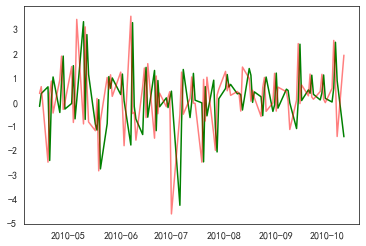

In [ ]:
plt.plot(pred.diff()[500:600],c='g')
plt.plot(data_diff[500:600],c='r',alpha=0.5)
plt.savefig('黄金涨幅对比图.png')
plt.show()

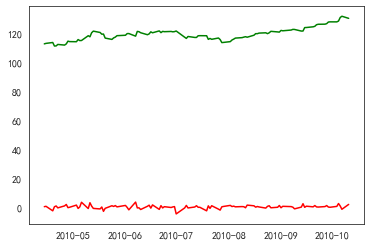

In [ ]:
plt.plot(data_diff[500:600],c='r')
plt.plot(pred[500:600],c='g')
plt.savefig('黄金涨幅对比图.png')
plt.show()

虽然大幅涨势没有预测出来但是整体的峰值基本还是预测出来了。  
这里仅介绍了参数的选择，比特币同理，后续使用预测时不进行解释。这里预测结果仅为示意图，后续不需要使用，每一个使用的数据都是刚预测出来的。

In [ ]:
# data = df['Value'].copy()
# data_diff=data
# data_diff.index=df['Date'].copy()
# data_diff=data_diff.diff().dropna()
# model = st.arma_order_select_ic(data_diff, max_ar=5, max_ma=5, ic=['aic', 'bic', 'hqic'])
# model.bic_min_order 

# model = ARIMA(data, order=(2,1,2))
# result = model.fit()
# pred = result.predict(2,1836)
# print(len(pred))
# print(pred[-10:])
# result_fina = np.array(pred[0:-10]) + (np.array(df['Value'].shift(1)[:-1]))